# Knowledge distillation
Suppose that we have a large network (*teacher network*) or an ensemble of networks which has a good accuracy but doesn't fit into memory/runtime requirements. Instead of training a smaller network (*student network*) directly on the original dataset, we can train this network to predict outputs of teacher networks. It turns out that the perfomance could be even better! This approach doesn't help with training speed, but can be quite beneficial when we'd like to reduce the model size for low-memory devices.

* https://www.ttic.edu/dl/dark14.pdf
* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322

Even the completely different ([article](https://arxiv.org/abs/1711.10433)) architecture can be used in a student model, e.g. you can approximate an autoregressive model (WaveNet) by a non-autoregressive one.

# Task
## 1. Teacher network
Train good enough (teacher) network, achieve >=35% accuracy on validation set of Tiny Imagenet (you can reuse any network from homework part 1 here).

In [1]:
from lightning.pytorch.loggers import WandbLogger
import wandb
wandb.finish()

In [2]:
NUM_TRAIN_EPOCHS = 60

In [3]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was already downloaded to './tiny-imagenet-200.zip'. Skip downloading
Extract downloaded dataset to '.'


In [4]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [5]:
!nvidia-smi

Tue Oct 10 05:19:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080         Off| 00000000:01:00.0 Off |                  N/A |
| 32%   34C    P8               15W / 215W|   1240MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter(0.25, 0.25, 0.25, 0.25)
     # you may add any other transforms here
    ]
)

val_transforms = transforms.Compose([transforms.ToTensor()])

In [7]:
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [00:23<00:00,  8.61it/s]


In [8]:
from tiny_img_dataset import read_rgb_image
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list(set([x[1] for x in annotations])))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = read_rgb_image(img_name)
            
            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

In [9]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:02<00:00, 4263.80it/s]


In [10]:
batch_size = 256
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
import lightning.pytorch as pl
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

In [12]:
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    

In [13]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, 'same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        
        residual = self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x)))))
        # print(self)
        # print('Residual:', residual.shape)
        # print('X:', x.shape)
        if self.conv3 is not None:
            x = self.conv3(x)
            # print('here')
        # print('-----')
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    # config = [[32, 32], [64, 64], [128, 128]]
    # model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    config = [[16, 16], [32, 32], [64, 64]]
    model.add_module('init_conv', ConvBNRelu(3, 16, kernel_size=7, stride=2, padding=3))
    

    in_channels = 16
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            padding = 1 if stride!=1 else 'same'

            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f'resnet_block_2_{i}_{j}', ResNetBlock2(in_channels, out_channels, 3, stride, padding))
            in_channels = out_channels

    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

In [14]:
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

In [15]:
class ModelWrapper(pl.LightningModule):
    def __init__(self, model, loss):
        super().__init__()
        self.model = model
        self.loss = loss
        self.val_losses = []
        self.train_losses = []

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        X_batch, y_batch = batch
        predictions = self.model(X_batch)
        loss = self.loss(predictions, y_batch)
        self.log("train_loss", loss)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        X_batch, y_batch = batch
        logits = self.model(X_batch)
        loss = self.loss(logits, y_batch)
        self.log("val_loss", loss)
        self.val_losses.append(loss.item())
        y_pred = logits.max(1)[1].data
        self.log("val_accuracy", np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [16]:
model = create_resnet_like_network().to(device)
model_wrapper = ModelWrapper(model, compute_loss)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def launch_run(wrapper, train_loader, val_loader):
    wandb.finish()
    wandb_logger = WandbLogger(project="HW1_part2")
    trainer = pl.Trainer(max_epochs=NUM_TRAIN_EPOCHS, logger=wandb_logger)
    trainer.fit(model=wrapper, train_dataloaders=train_loader, val_dataloaders=val_loader)
    wandb.finish()

def plot_losses(wrapper):
    list1 = wrapper.train_losses # Your train losses with 782 values
    list2 = wrapper.val_losses  # Your validation losses with 82 values

    # Create x-axis values based on the length of each list
    x1 = range(len(list1))
    x2 = list(range(len(list2)))
    x2 = np.array(x2) * (len(x1) / len(x2))
    x2 = [int(x) for x in x2]

    # Plot list 1 in blue and list 2 in red
    plt.figure(figsize=(12, 8))
    plt.plot(x1, list1, label='Train Loss')
    plt.plot(x2, list2, label='Validation Loss')

    # Add labels and legend
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot
    plt.show()

In [18]:
launch_run(model_wrapper, train_batch_gen, val_batch_gen)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mishacamry. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 189 K 
-------------------------------------
189 K     Trainable params
0         Non-trainable params
189 K     Total params
0.760     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss,█▆▅▅▄▄▄▃▃▄▃▃▃▃▂▃▂▂▃▃▂▂▂▁▂▂▂▂▂▂▂▁▁▂▁▁▂▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇████████████████
val_loss,█▆▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,59
train_loss,2.24354
trainer/global_step,23459
val_accuracy,0.3795
val_loss,2.65433


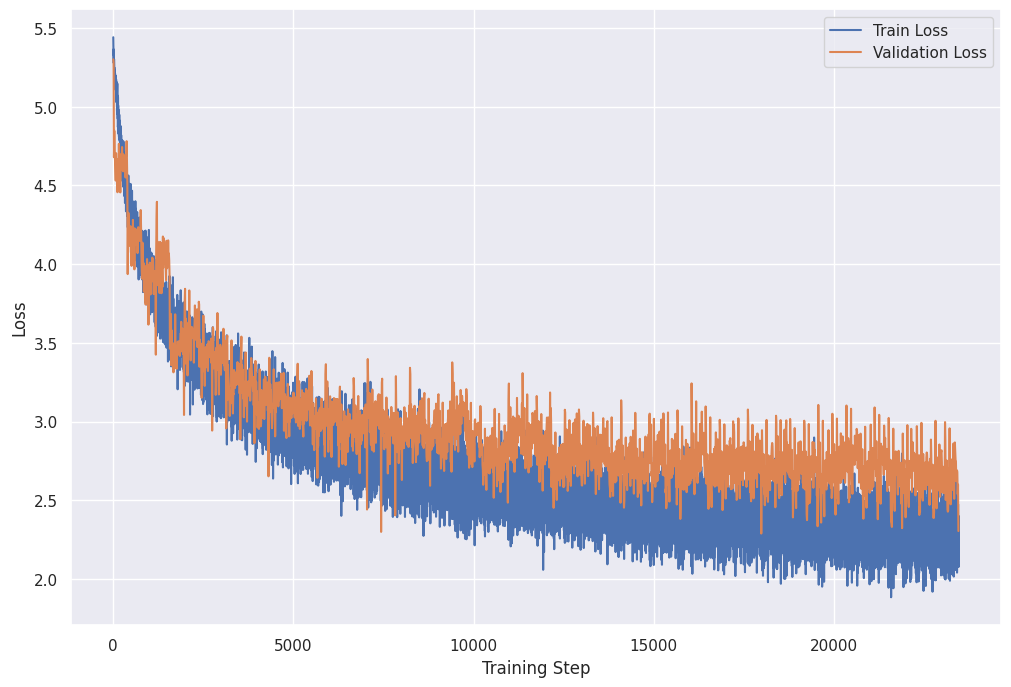

In [19]:
plot_losses(model_wrapper)

In [20]:
torch.save(model.state_dict(), "teacher_model.pt")

## 2. Student network 
Train small (student) network, achieve 20-25% accuracy, draw a plot "training and testing errors vs train step index"

In [21]:
def create_resnet_student_network():
    model = nn.Sequential()
    
    # config = [[16, 16], [32, 32], [64, 64]]
    # model.add_module('init_conv', ConvBNRelu(3, 16, kernel_size=7, stride=2, padding=3))
    config = [[8, 8], [16, 16], [32, 32]]
    model.add_module('init_conv', ConvBNRelu(3, 8, kernel_size=7, stride=2, padding=3))


    in_channels = 8
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            padding = 1 if stride!=1 else 'same'

            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f'resnet_block_2_{i}_{j}', ResNetBlock2(in_channels, out_channels, 3, stride, padding))
            in_channels = out_channels

    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

In [22]:
small_model = create_resnet_student_network().to(device)
model_wrapper = ModelWrapper(small_model, compute_loss)

In [23]:
launch_run(model_wrapper, train_batch_gen, val_batch_gen)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 51.8 K
-------------------------------------
51.8 K    Trainable params
0         Non-trainable params
51.8 K    Total params
0.207     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▃▃▄▃▃▄▃▃▃▂▃▂▃▂▃▁▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▁▃▄▄▄▅▅▅▆▅▆▆▆▆▆▇▇▆▇▇▇███▅█▇███▇█▇██▇███
val_loss,█▇▅▅▄▄▃▃▃▃▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▄▁▂▁▁▁▁▁▁▁▁▂▁▁▁
epoch,59
train_loss,2.98908
trainer/global_step,23459
val_accuracy,0.2623
val_loss,3.2342


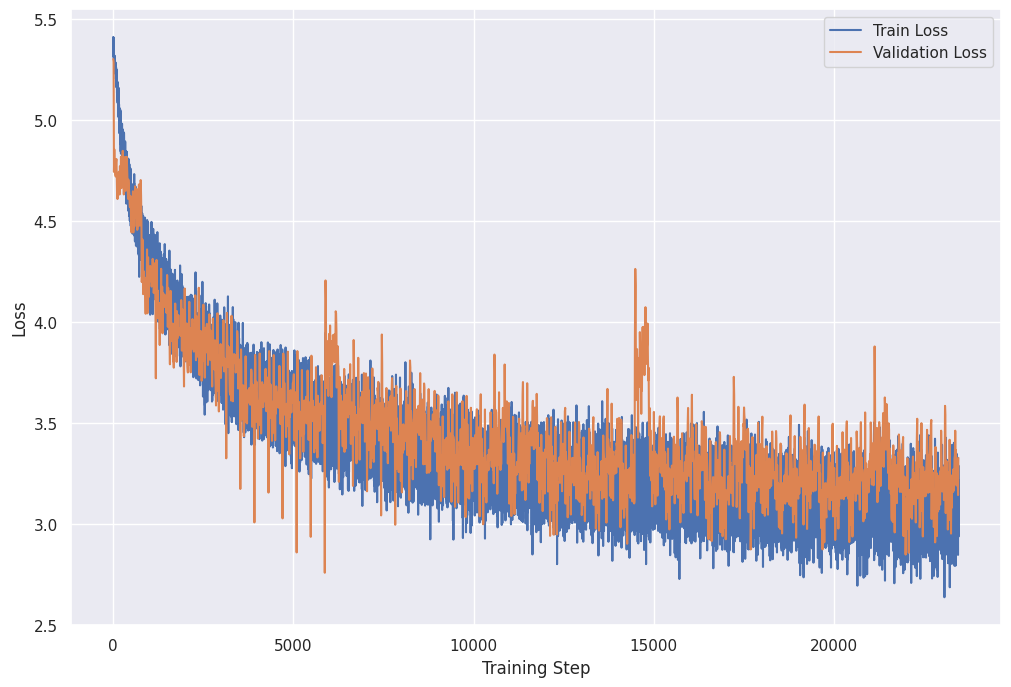

In [24]:
plot_losses(model_wrapper)

In [25]:
torch.save(small_model.state_dict(), "student_model.pt")

#### Accuracy on Small model: 0.2623
#### Accuracy on Large model: 0.3795

## 3. Knowledge distillation
![image info](https://miro.medium.com/max/875/1*WxFiH3XDY1-28tbyi4BGDA.png)

At this block you will have to retrain your student network using "knowledge distillation" technique. **Distill teacher network with student network, achieve at least +1% improvement in accuracy over student network accuracy.**

The training procedure is the same as for training the student network from scratch except the loss formulation.

Assume that 
- $z_i$ are logits predicted by the student network at the current step for an input image
- $v_i$ are logits predicted by the (freezed) teacher network
- $y_i$ are one-hot encoded label of the input image
- $p_i = \frac{\exp{z_i}}{\sum_j \exp{z_j}}$ - logits $z_i$ after sofrmax
- $q_i = \frac{\exp{\frac{z_i}{T}}}{\sum_j \exp{\frac{z_j}{T}}}$, where $T$ is softmax temperature
- $r_i = \frac{\exp{\frac{v_i}{T}}}{\sum_j \exp{\frac{v_j}{T}}}$, where $T$ is the same softmax temperature as for $q_i$

The loss for knowledge distillation: $$-\sum_i y_i \log p_i - \alpha \sum_i r_i \log q_i$$

$T$ and $\alpha$ are hyperparameters. 

- There is a good practice of using softmax with high temperature to obtain "soft" distributions, you can start with $T=10$. Check the [post](https://medium.com/mlearning-ai/softmax-temperature-5492e4007f71) with good visualizations on how the temperature affects the softmax output. 
- For $\alpha$ there is the following note in the original [paper](https://arxiv.org/pdf/1503.02531.pdf):

> Since the magnitudes of the gradients produced by the soft targets scale as $1/T^2$ it is important to multiply them by $T^2$ when using both hard and soft targets. This ensures that the relative contributions of the hard and soft targets remain roughly unchanged if the temperature used for distillation is changed while experimenting with meta-parameters.

In [26]:
def compute_soft_loss(student_predictions, teacher_predictions, t):
    student_log_probs = torch.log_softmax(student_predictions / t, dim=-1)
    teacher_probs = torch.softmax(teacher_predictions / t, dim=-1)
    return -(student_log_probs * teacher_probs).mean()

def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

def compute_distillation_loss(student_predictions, teacher_predictions, gt, alpha, t):
    teacher_loss = compute_soft_loss(student_predictions, teacher_predictions, t)
    # print(student_probs)
    # print(real_probs.shape)
    # teacher_loss = compute_loss(student_probs, teacher_probs)
    student_loss = compute_loss(student_predictions, gt)

    total_loss = student_loss + alpha * teacher_loss
    # print(total_loss.item(), student_loss.item(), teacher_loss.item())
    return total_loss

In [27]:
class DistillationWrapper(pl.LightningModule):
    def __init__(self, teacher_model, student_model, loss, t=12.5):
        super().__init__()
        self.teacher_model = teacher_model
        self.teacher_model.eval()
        self.student_model = student_model
        self.loss = loss
        self.t = t
        self.val_losses = []
        self.train_losses = []

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        X_batch, y_batch = batch

        with torch.no_grad():
            self.teacher_model.eval()
            teacher_predictions = self.teacher_model(X_batch)

        student_predictions = self.student_model(X_batch)
        loss = self.loss(student_predictions, teacher_predictions, y_batch, self.t**2, self.t)
        self.log("train_loss", loss)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        X_batch, y_batch = batch

        with torch.no_grad():
            self.teacher_model.eval()
            teacher_predictions = self.teacher_model(X_batch)

        student_predictions = self.student_model(X_batch)
        loss = self.loss(student_predictions, teacher_predictions, y_batch, self.t**2, self.t)
        self.log("val_loss", loss)
        self.val_losses.append(loss.item())

        y_pred = student_predictions.max(1)[1].data
        self.log("val_accuracy", np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [28]:
teacher_model = create_resnet_like_network().to(device)
teacher_model.load_state_dict(torch.load('teacher_model.pt'))

for p in teacher_model.parameters():
    p.requires_grad = False

In [29]:
student_model = create_resnet_student_network().to(device)

In [30]:
distillation_wrapper = DistillationWrapper(teacher_model, student_model, compute_distillation_loss)

In [31]:
launch_run(distillation_wrapper, train_batch_gen, val_batch_gen)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | teacher_model | Sequential | 189 K 
1 | student_model | Sequential | 51.8 K
---------------------------------------------
51.8 K    Trainable params
189 K     Non-trainable params
241 K     Total params
0.967     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss,█▇▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▃▂▂▂▃▂▂▂▂▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▆█▇▇████▇▇▇█▇██
val_loss,█▇▅▄▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▃▁▁▁▁▁▁▁▂▂▂▁▂▁▁
epoch,59
train_loss,7.11701
trainer/global_step,23459
val_accuracy,0.2761
val_loss,7.28746


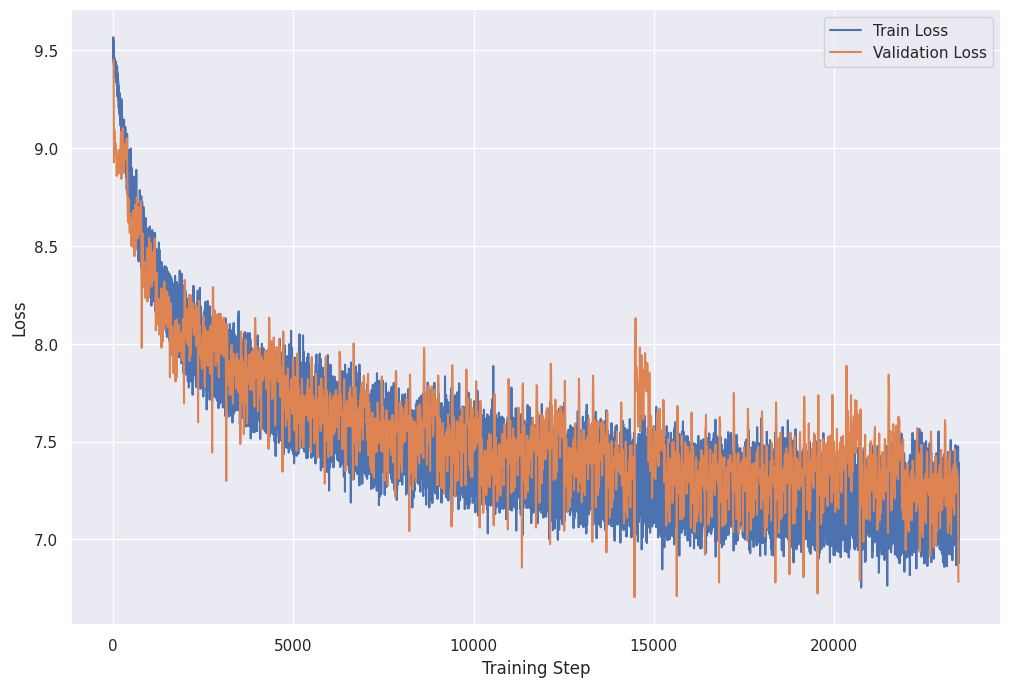

In [32]:
plot_losses(distillation_wrapper)

**Final notes**:
- Please, don't cheat with early-early-early stopping while training of the student network. Make sure, it  converged.
- Logits still carry more information than the probabilities after softmax.
- Don't forget to use your teacher network in 'eval' mode. And don't forget your main objective.

**Future readings**
- ["Born again neural networks"](https://arxiv.org/pdf/1805.04770.pdf) - knowledge distillation may give benefits even when teacher and student networks have the same architecture.
- ["Prune your model before distill it"](https://arxiv.org/pdf/2109.14960.pdf) - pruning of the teacher model before distillation may improve quality of student model

#### Accuracy on Small model: 0.2623
#### Accuracy on Large model: 0.3795
#### Accuracy on Small model + Knowledge Distillation: 0.2761 (+1.4%)